# Ordinal probit models

This note briefly reviews ordinal models from a psychohysics perspective. For more on Ordinal GP, see https://www.jmlr.org/papers/volume6/chu05a/chu05a.pdf. 

In standard psychophysics theory, we have two stimuli, $x_1$ and $x_2$, and we assume the latent representations of both are corrupted by noise to yield latent percepts: 
$$
\begin{aligned}
\widetilde{f}(x_1) &= f(x_1) + \epsilon_1, \epsilon_1 \sim \mathcal{N}(0, \sigma)\\
\widetilde{f}(x_2) &= f(x_2) + \epsilon_2, \epsilon_2 \sim \mathcal{N}(0, \sigma),
\end{aligned}
$$
where under Weber's law we expect $f(x)$ to be the log function but in AEPsych we assume it is more general. For symmetric noise distributions, this is equivalent to saying $f(x_n) = \widetilde{f}(x_n) + \epsilon_n$, which is equivalent to the following model: 

$$
\begin{aligned}
f(x_1) &\sim \mathcal{N}(\widetilde{f}(x_1), \sigma^2)\\
f(x_2) &\sim \mathcal{N}(\widetilde{f}(x_2), \sigma^2). 
\end{aligned}
$$

Then when we ask the participant to respond based on which stimulus is stronger, we ask them to respond yes if $f(x_1)>f(x_2)$ and respond no otherwise. By definition, 

$$
\begin{aligned}
p(f(x_1) > f(x_2)) &=p(f(x_1) - f(x_2) > 0)\\
&= \Phi(f(x_1)-f(x_2)), 
\end{aligned}
$$

which is the standard pairwise model available in AEPsych. We can ask the participant to change their response criteria, which would imply a model like $p(f(x_1) > f(x_2)) =p(f(x_1) - f(x_2) > d)$ for criterion $d$. In detection experiments, we treat $f(x_2)$ as a constant, and for an $f(\cdot)$ that can model shifts it can just be zero, yielding $z(x\mid f) = \Phi(f(x))$, which is the standard single model available in AEPsych. 

However, we can extend this ideaa to a larger number of ratings. Suppose that: 
$$
\begin{aligned}
\widetilde{f}(x_1) &= f(x_1) + \epsilon_1, \epsilon_1 \sim \mathcal{N}(0, \sigma^2)\\
\ldots\\
\widetilde{f}(x_n) &= f(x_n) + \epsilon_n, \epsilon_n \sim \mathcal{N}(0, \sigma^2),
\end{aligned}
$$
for $n$ stimuli, and equivalently $f(x) \sim \mathcal{N}(\widetilde{f}(x), \sigma^2)$ (i.e.\ it's the same exact model). Then we ask the participant to make one of $n$ responses corresponding to the strength of the stimulus (for example "no stimulus", "weak stimulus", "moderate stimulus", "strong stimulus", "very strong stimulus" for a 5-point scale). We assume that the participant has a set of internal criteria $\{d_1, \cdots, d_{k+1}\}$ subdividing their internal perceptual intensity space into $k$ regions. Assuming each region in the space must be assigned to some response, we set $d_1=-\infty$ and $d_{k+1} = \infty$. Then the probability that a participant picks a rating is the probability that the noisy internal percept falls into the appropriate bucket, i.e. $p(y=k\mid x) = p(d_k < f(x) \le d_{k+1})$. This is simply the proportion of $f(x)$ that falls between $d_k$ and $d_{k+1}$, i.e.\ it is the difference between the CDF of $f(x)$ evaluated at $d_{k+1}$ and $d_k$: 
$$
z_k(x\mid f) := p(d_k < f(x) \le d_{k+1}) = \Phi(d_{k+1}-f(x)) - \Phi(d_{k}-f(x)). 
$$
Supposing that we want the marginal response probability (integrating over the uncertainty in the GP), due to the linearity of expectation it is: 
$$
z_k(x) = \Phi\left(\frac{d_{k+1}-\mu(x)}{\sqrt{1+\sigma(x)^2}}\right) - \Phi\left(\frac{d_{k}-\mu(x)}{\sqrt{1+\sigma(x)^2}}\right), 
$$

Next we show how to generate and fit such data in AEPsych.  **Note that this should be considered alpha-level functionality that has not yet had the level of polish or testing as other models in AEPsych. However, we hope it proves useful.**

In [1]:
# imports and seeds
import gpytorch
import matplotlib.pyplot as plt
import numpy as np
import torch
from aepsych.benchmark.test_functions import novel_detection_testfun
from aepsych.utils import dim_grid, make_scaled_sobol
from scipy.stats import norm
from torch.distributions import Categorical, Normal


np.random.seed(1)
torch.manual_seed(1)

Text(0.5, 1.0, 'Latent function f(x)')

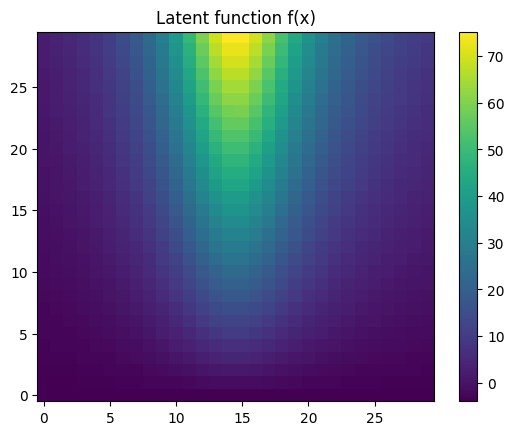

In [2]:
# Hairtie test function
lb = [-1, -1]
ub = [1, 1]

xgrid = dim_grid(lower=lb, upper=ub, dim=2)

fgrid = novel_detection_testfun(xgrid)

plt.imshow(fgrid.reshape(30, 30).T, aspect="auto", origin="lower")
plt.colorbar()
plt.title("Latent function f(x)")


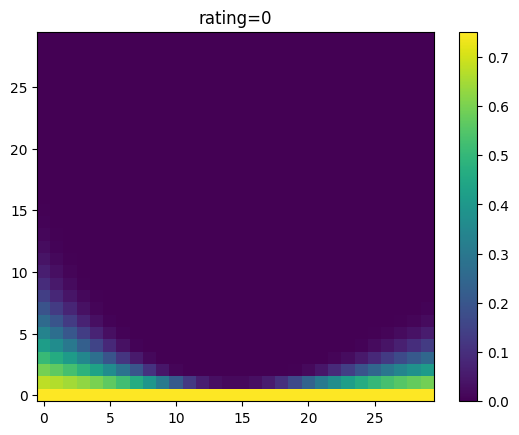

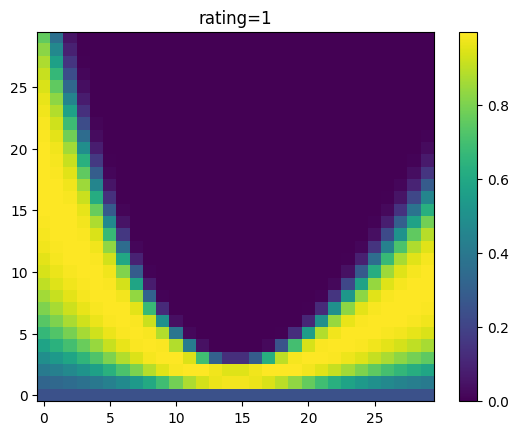

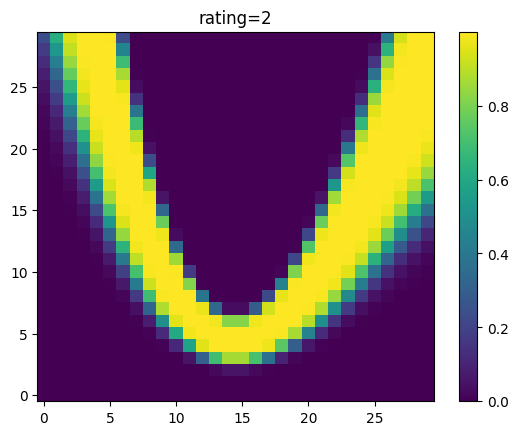

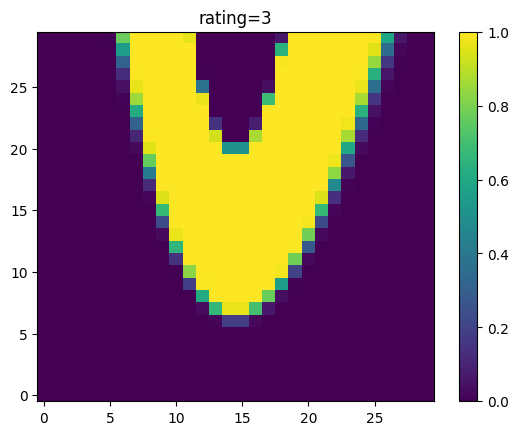

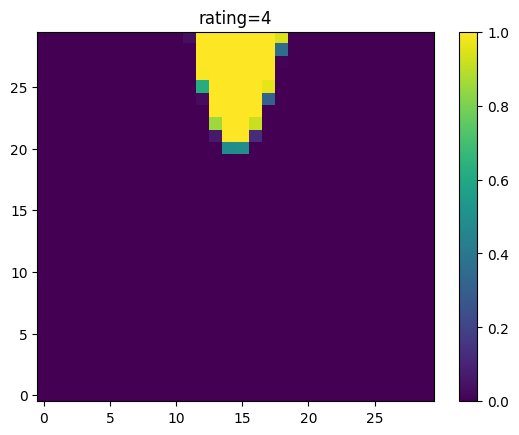

In [3]:
# First, pick the number of levels and make using evenly spaced cutpoints over the distribution of function values
n_levels = 5
cutpoints = np.quantile(fgrid, np.linspace(0.05, 0.95, n_levels - 1))


def make_prob_matrix(fgrid, cutpoints, n_levels):
    """
    Generates the matrix of response probabilities for each choice given function values, cutpoints, 
    and number of levels.
    """
    probs = np.zeros((*fgrid.shape, n_levels))

    probs[..., 0] = norm.cdf(cutpoints[0] - fgrid)

    for i in range(1, n_levels - 1):
        probs[..., i] = norm.cdf(cutpoints[i] - fgrid) - norm.cdf(cutpoints[i - 1] - fgrid)

    probs[..., -1] = 1 - norm.cdf(cutpoints[-1] - fgrid)
    return probs


probs_grid = make_prob_matrix(fgrid, cutpoints, n_levels)

# now see what the probabilities of each rating look like
for i in range(n_levels):
    plt.figure()
    plt.imshow(probs_grid[..., i].reshape(30, 30).T, aspect="auto", origin="lower")
    plt.title(f"rating={i}")
    plt.colorbar()

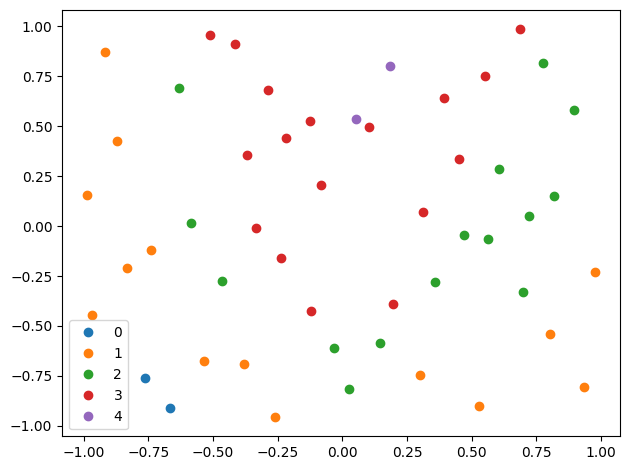

In [4]:
# now generate some data from the categorical distribution defined over a set of training locations
xtrain = make_scaled_sobol(lb=lb, ub=ub, size=50)
ftrain = novel_detection_testfun(xtrain)
train_probs = make_prob_matrix(ftrain, cutpoints=cutpoints, n_levels=n_levels)
ytrain = Categorical(probs=torch.Tensor(train_probs)).sample(torch.Size([1])).squeeze()

for i in range(n_levels):
    plt.plot(xtrain[ytrain == i, 0], xtrain[ytrain == i, 1], "o", label=i)
    plt.legend()
plt.tight_layout()

2023-02-21 19:43:31,430 [INFO   ] Starting fit...
2023-02-21 19:43:31,922 [INFO   ] Fit done, time=0.4902503490447998


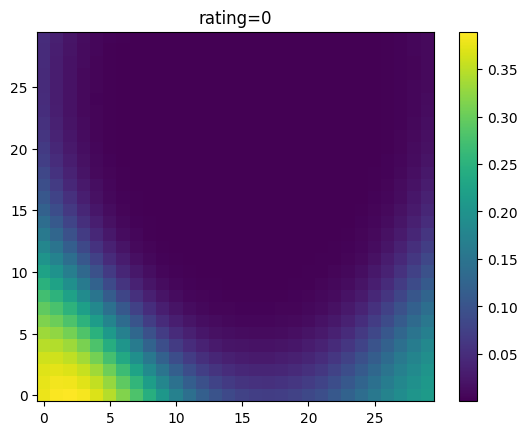

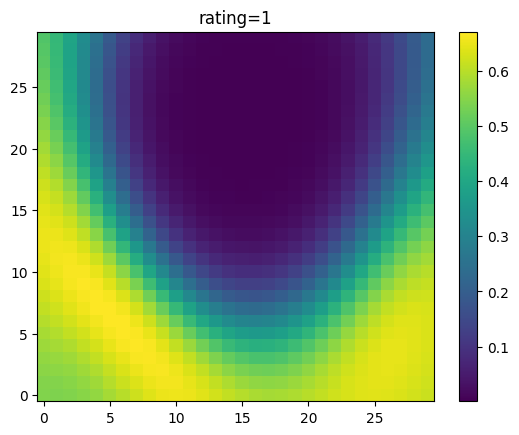

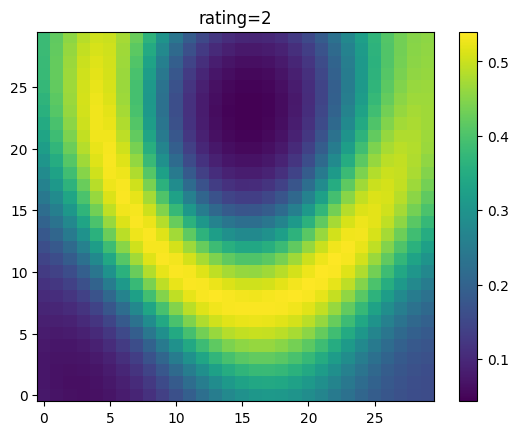

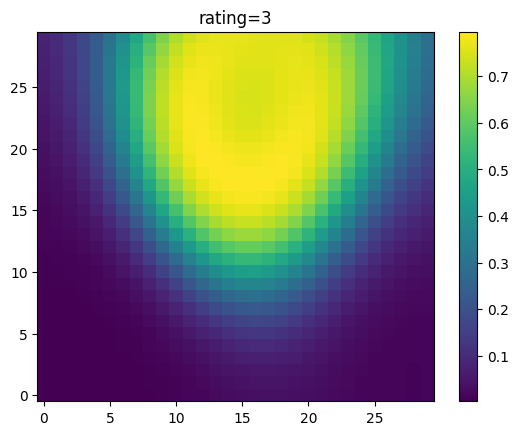

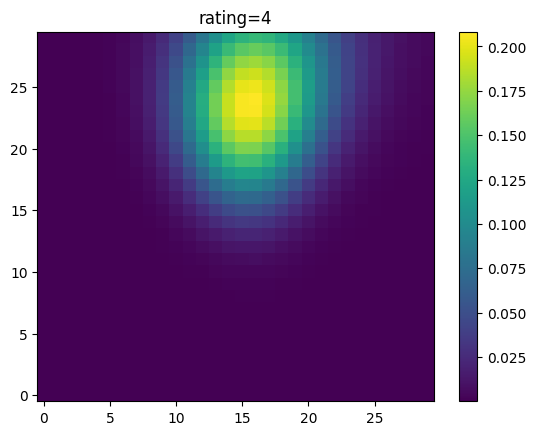

In [5]:
from aepsych.models import OrdinalGPModel
from aepsych.likelihoods import OrdinalLikelihood

# OrdinalGPModel is a thin wrapper around the regular GPClassificationModel, but removes the shift and scale, since those are invariant for the ordinal model, 
# and adds a convenience method for predicting response probabilities

model = OrdinalGPModel(lb=lb, ub=ub, dim=2, likelihood=OrdinalLikelihood(n_levels=n_levels))
model.fit(xtrain, ytrain, warmstart_hyperparams=True, warmstart_induc=True)

# generate predicted response probabilities and plot, showing we recover a function that looks broadly close to the original
probs_hat = model.predict_probs(xgrid).detach().numpy()
for i in range(n_levels):
    plt.figure()
    plt.imshow(probs_hat[..., i].reshape(30, 30).T, aspect="auto", origin="lower")
    plt.title(f"rating={i}")
    plt.colorbar()


# Ordinal Probit models in a full experiment loop
Ordinal models can be used with any acquisition function, but AEPsych today does not have ones that have been specifically validated for this setting, so in this example we just use sobol: 

In [6]:
%%bash --bg

aepsych_server --ip 0.0.0.0 --port 5555 database --db likert_example.db

In [7]:
from aepsych_client import AEPsychClient
client = AEPsychClient(ip="0.0.0.0", port=5555)

# this is just configs/likert_exploration_example.ini
config_str = """
### Example config for ordinal (likert) data
# Assuming you are learning a latent value from k-point scores,  the
# only things that need to be changed for a
# typical experiment are:
# 1. parnames, lb and ub under [common], and optionally target.
# 2. min_asks under init_strat
# 3. n_levels under OrdinalLikelihood

## The common section includes global server parameters and parameters
## reused in multiple other classes
[common]
parnames = [par1, par2] # names of the parameters
lb = [-1, -1] # lower bounds of the parameters, in the same order as above
ub = [1, 1] # upper bounds of parameter, in the same order as above
stimuli_per_trial = 1 # the number of stimuli shown in each trial; 1 for single, or 2 for pairwise experiments
outcome_types = [ordinal] 
strategy_names = [init_strat] # The strategies that will be used, corresponding to the named sections below

# Configuration for the initialization strategy, which we use to gather initial points
# before we start doing model-based acquisition
[init_strat]
min_asks = 50 # number of sobol trials to run
generator = SobolGenerator # The generator class used to generate new parameter values
model = OrdinalGPModel
refit_every = 50

## Below this section are configurations of all the classes defined in the section above,
## matching the API in the code.

## OrdinalGPModel model settings.
[OrdinalGPModel]
# Number of inducing points for approximate inference. 100 is fine for 2d and overkill for 1d;
# for larger dimensions, scale this up.
inducing_size = 100
# ordinal_mean_covar_factory has better defaults for the ordinal setting than the default factory, 
mean_covar_factory = ordinal_mean_covar_factory
likelihood = OrdinalLikelihood

[OrdinalLikelihood]
n_levels = 5
"""



OSError: [WinError 10049] The requested address is not valid in its context

In [ ]:
# configure AEPsych to run this experiment
client.configure(config_str=config_str, config_name="likert_sobol_2d")

def simulate_trial(trial_config):
    """
    Generate synthetic responses from our model (defined above)
    """
    x = torch.Tensor(np.r_[trial_config['config']['par1'][0], trial_config['config']['par2'][0]])
    p = make_prob_matrix(novel_detection_testfun(x), cutpoints=cutpoints, n_levels=n_levels)
    return Categorical(probs=torch.Tensor(p)).sample(torch.Size([1])).squeeze().item()


# run a full synthetic experiment loop
finished = False
trial_number = 1
while not finished:
    trial_config = client.ask()
    outcome = simulate_trial(trial_config=trial_config)
    client.tell(config=trial_config['config'], outcome=outcome)
    finished = trial_config["is_finished"]
    trial_number += 1

client.finalize()

# Replaying the experiment and analyzing data

This section is nearly identical to the analysis in the basic analysis tutorial, but we can add some likert-specific plots

In [ ]:
from aepsych.server import AEPsychServer

serv = AEPsychServer(database_path="likert_example.db")
strat = serv.get_strat_from_replay()
strat.fit() # make sure the model is fully updated with latest data

In [ ]:
# we can look at the data
print(strat.x)
print(strat.y)
for i in range(strat.model.likelihood.n_levels):
    plt.plot(strat.x[strat.y == i, 0], strat.x[strat.y == i, 1], "o", label=i)
    plt.legend()
plt.tight_layout()

In [ ]:
# we can generate the same plots as from when we fit the model above: 
probs_hat = strat.model.predict_probs(xgrid).detach().numpy()
for i in range(n_levels):
    plt.figure()
    plt.imshow(probs_hat[..., i].reshape(30, 30).T, aspect="auto", origin="lower")
    plt.title(f"rating={i}")
    plt.colorbar()